# Get field moments df

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./field_info')
from field_grid import *
from format_field import get_field_df

In [3]:
#Point to the data and get the df
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/'
file = "60Hr_Average_Comparison_all_3956_3997_norescut.txt"
file = path + file
df_field = get_field_df(file)

# Get the CTAGs

In [4]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/muon_info'
sys.path.append(path)
from simple_ctags import get_ctags

In [5]:
data = get_ctags("2018-04-22 00:00:00", "2018-04-25 00:00:00",'localhost')
df_muons = pd.DataFrame.from_dict(data, orient="index",columns=['ctags'])
df_muons.index.name = 'DateTime'
df_muons.index = pd.to_datetime(df_muons.index)
df_muons = df_muons.sort_values(by=['DateTime'])

# Combine Field Moments and CTAGs Data

In [6]:
#Get the muons/ctag time interval (shorter than the field's time interval)
muons_time_interval = (df_muons.index.values[1].astype('int64')
                      - df_muons.index.values[0].astype('int64'))//1e9

#upsample each dataframe to 1 second                      
df_muons = df_muons.resample('1S').ffill()
df_field = df_field.resample('1S').ffill()

#Join the dataframes
df_total = df_field.join(df_muons)
df_total = df_total.fillna(0)

#calculate ctags per second and add it as a column
factor = 1/float(muons_time_interval)
df_total['ctags_per_second'] = df_total['ctags'].astype(float)*factor

# Get the CTAG weighted average multipole moments

In [7]:
total_ctags = df_total["ctags_per_second"].sum()
b = [
    (df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    0,
    (df_total["NS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]
eb = [
    (df_total["eD"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eNQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eSQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eNS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]

# Get the ctag weighted average field grid

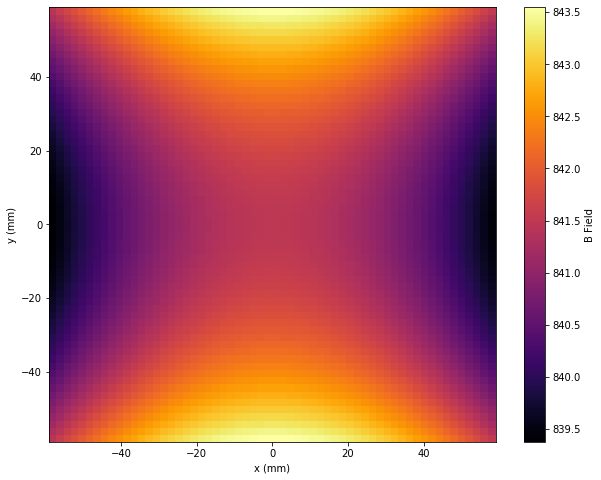

In [8]:
#First the field
df_field_grid = get_field_grid(b)
fig = plot_field(df_field_grid)
fig

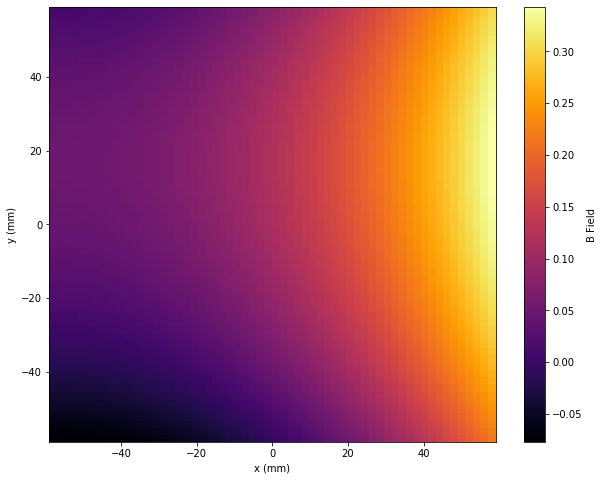

In [9]:
#Next the error on the field
df_field_grid_error = get_field_grid(eb)
fig = plot_field(df_field_grid_error)
fig

# Get the tracker data

In [10]:
import sys
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/tracker_info'
sys.path.append(path)
from beam_moments import *

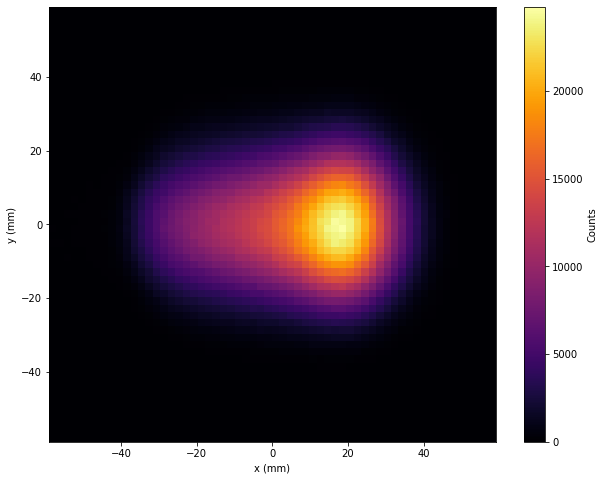

In [11]:
df_tracker = get_df_tracker()
#only look at station 12
df_tracker = df_tracker[df_tracker["Station"] == 'station12']
fig = plot_beam(df_tracker,bins=60)
fig

# Combine ctag weighted field with the beam

In [12]:
B = (df_tracker['counts']*df_field_grid['B']).sum()/(df_tracker['counts'].sum())
eB = (df_tracker['counts']*df_field_grid_error['B']).sum()/(df_tracker['counts'].sum())
print("Final Result = ",B,"+/-",eB)

Final Result =  841.3665011990851 +/- 0.13769484134088417


# For comparison, get the time average (ie no CTAG weighting)




In [13]:
#recalculate the 'average' moments
b = [df_total["D"].mean(), df_total["NQ"].mean(), 
      0, df_total["NS"].mean()]

eb = [df_total["eD"].mean(), df_total["eNQ"].mean(), 
      df_total["eSQ"].mean(), df_total["eNS"].mean()]

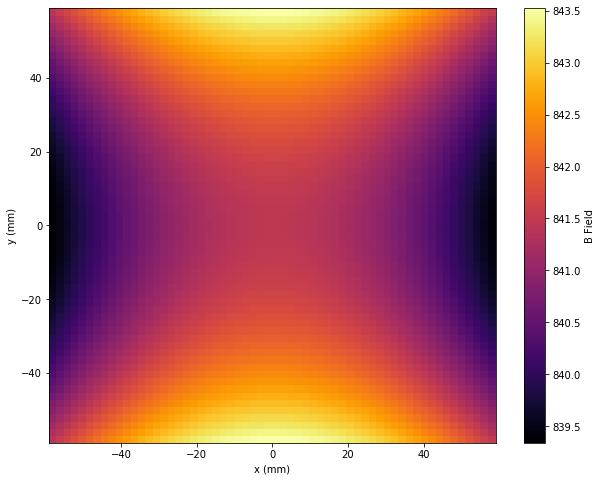

In [14]:
#re-plot the field
df_field_grid = get_field_grid(b)
fig = plot_field(df_field_grid)
fig

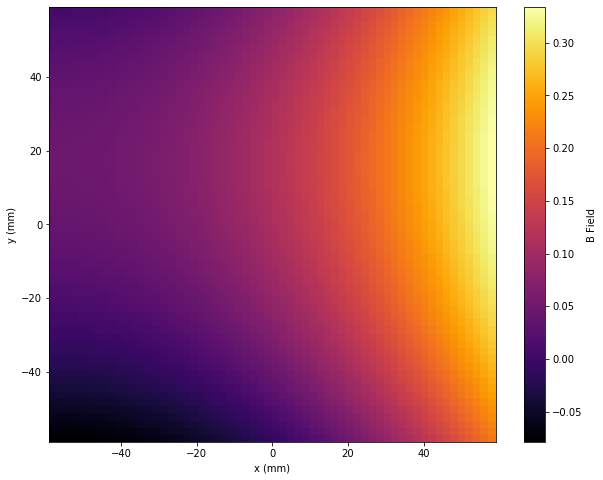

In [15]:
#re-plot the error on the field
df_field_grid_error = get_field_grid(eb)
fig = plot_field(df_field_grid_error)
fig

In [16]:
#Recacluate the answer
B_new = (df_tracker['counts']*df_field_grid['B']).sum()/(df_tracker['counts'].sum())
eB_new = (df_tracker['counts']*df_field_grid_error['B']).sum()/(df_tracker['counts'].sum())
print("Time averaged Result = ",B_new,"+/-",eB_new)
print("compare with ",B,"+/-",eB)

Time averaged Result =  841.3368484884263 +/- 0.1326646428399825
compare with  841.3665011990851 +/- 0.13769484134088417
